# YoloV5 ONNX inference example

Can reference the [link](https://github.com/ultralytics/yolov5/issues/343#issuecomment-658021043). It's a really interesting discussion thread about YoloV5 ONNX detection.

# Prepare environment and lib path

In [ ]:
!pip install onnxruntime torch torchvision --upgrade
# !pip install onnxruntime     # CPU build
# pip install onnxruntime-gpu   # GPU build

In [ ]:
# !rm ./*.onnx
# !rm -rf yolov5

In [1]:
# run 0-yolov5-onnx to generate the onnx model
!cp ../2-yolov5-onnx/yolov5s_detect.onnx .

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1798 (delta 0), reused 0 (delta 0), pack-reused 1794
Receiving objects: 100% (1798/1798), 5.07 MiB | 38.44 MiB/s, done.
Resolving deltas: 100% (1167/1167), done.


In [3]:
# extend yolov5 python lib path
import os, sys
fp_yolov5 = os.path.abspath(os.getcwd()) + "/yolov5"
sys.path.append(fp_yolov5)
sys.path

['',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python36.zip',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ec2-user/.ipython',
 '/home/ec2-user/SageMaker/myAWSStudyBlog/sagemaker-greengrass/1-yolov5-onnx-inference/yolov5']

In [4]:
import onnxruntime
import numpy as np
from numpy import asarray
from PIL import Image

In [5]:
# import yolov5 utils
from utils.datasets import *
from utils.utils import *

In [6]:
fp_onnx = './yolov5s_detect.onnx'
fp_img = fp_yolov5 + '/inference/images/zidane.jpg'

# Define the image_letterbox function

In [7]:
def image_letterbox(fp_image, desired_size):
    img_pil = Image.open(fp_img)
    # resize inplace to save memory
    img_pil.thumbnail(desired_size)
    new_size = img_pil.size
    img_padding = Image.new("RGB", desired_size)
    img_padding.paste(img_pil, ((desired_size[0]-new_size[0])//2, (desired_size[1]-new_size[1])//2))
    return img_padding

### Onnx detection output

* Trace the [issue343](https://github.com/ultralytics/yolov5/issues/343)
* Trace the [detect.py](https://github.com/ultralytics/yolov5/blob/02445d176d3a8756fd5f2800b66137beeac9e573/detect.py#L65)

In [8]:
def detect_onnx(fp_onnx, image_path=None):
    """
        Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """
    session = onnxruntime.InferenceSession(fp_onnx)
    # print("The model expects input shape: ", session.get_inputs()[0].shape)
    batch_size = session.get_inputs()[0].shape[0]
    img_size_h = session.get_inputs()[0].shape[2]
    img_size_w = session.get_inputs()[0].shape[3]

    # PIL letterbox to 640x640
    im_letterbox = image_letterbox(fp_img, (img_size_w, img_size_h))
    # convert PIL to numpy array
    np_image = np.array(im_letterbox)
    img_in = np.transpose(np_image, (2, 0, 1)).astype(np.float32)  # HWC -> CHW
    img_in = np.expand_dims(img_in, axis=0)
    img_in /= 255.0
    print("Shape of the image input shape: ", img_in.shape)

    # inference, https://github.com/ultralytics/yolov5/blob/02445d176d3a8756fd5f2800b66137beeac9e573/detect.py#L65
    input_name = session.get_inputs()[0].name
    pred = session.run(None, {input_name: img_in})[0]
    # Apply NMS
    pred = non_max_suppression(torch.from_numpy(pred), conf_thres=0.5, iou_thres=0.6, agnostic=False)
    return pred

In [9]:
pred = detect_onnx(fp_onnx=fp_onnx, image_path=fp_img)
pred

Shape of the image input shape:  (1, 3, 640, 640)


[tensor([[370.94177, 157.86243, 573.62964, 499.71362,   0.86514,   0.00000],
         [ 52.95384, 240.58154, 498.66382, 495.88342,   0.67070,   0.00000],
         [216.90196, 360.82730, 252.01967, 499.83145,   0.59316,  27.00000]])]

# Plot Result

In [10]:
names =['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

In [11]:
def draw_onnx(pred, fp_img, desired_size=(640,640)):
    im_letterbox = image_letterbox(fp_img, desired_size)
    np_image = np.array(im_letterbox) # convert PIL to numpy array (H, W, C)
    output_np_images = []
    s = ''
    for i, det in enumerate(pred):
        if det is not None and len(det):
            det[:, :4] = det[:, :4].round()
            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += '%g %ss, ' % (n, names[int(c)])  # add to string
            print(s)

            for *xyxy, conf, cls in det:
                label = '%s %.2f' % (names[int(cls)], conf)
                plot_one_box(xyxy, np_image, label=label, color=colors[int(cls)], line_thickness=3)
            output_np_images.append(np_image)
    return output_np_images

2 persons, 1 ties, 


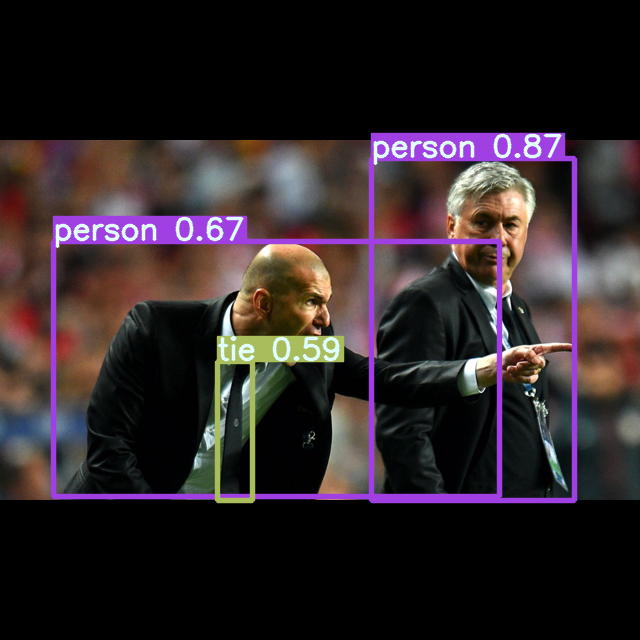

In [12]:
np_image = draw_onnx(pred, fp_img)[0]
img_pil = Image.fromarray(np_image)
display(img_pil)

# Experiement Image Helper script for letterbox

In [ ]:
fp_img = fp_yolov5 + '/inference/images/zidane.jpg'

img_pil = Image.open(fp_img)
# display(img_pil)

# convert image to numpy array
img_np = np.array(img_pil)
print('np shape: {} (H, W, C)'.format(img_np.shape))
print('PIL image size: {} (W, H)'.format(img_pil.size))

In [ ]:
# verify the transpose HWC -> CHW
x = np.ones((720, 1280, 3))
print(f'np shape: {x.shape} (H, W, C)')
print(f'yolo np shape: {np.transpose(x, (2, 0, 1)).shape} (C, H, W)')

In [ ]:
desired_size = 640, 640
img_pil.thumbnail(desired_size)
new_size = img_pil.size
print(new_size)
# display(img_pil)

In [ ]:
img_padding = Image.new("RGB", desired_size)
img_padding.paste(img_pil, ((desired_size[0]-new_size[0])//2, (desired_size[1]-new_size[1])//2))
print(img_padding.size)
display(img_padding)

# Reference and Others

In [ ]:
import cv2
import numpy as np

im_letterbox = image_letterbox(fp_img, (640, 640))
# convert PIL to numpy array (H, W, C)
np_image = np.array(im_letterbox)

s = ''
for i, det in enumerate(pred):
    if det is not None and len(det):
        det[:, :4] = det[:, :4].round()
        # Print results
        for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()  # detections per class
            s += '%g %ss, ' % (n, names[int(c)])  # add to string
        print(s)
        
        for *xyxy, conf, cls in det:
            label = '%s %.2f' % (names[int(cls)], conf)
            plot_one_box(xyxy, np_image, label=label, color=colors[int(cls)], line_thickness=3)
            
img_pil_op2 = Image.fromarray(np_image)
display(img_pil_op2)

In [ ]:
fp_onnx = './yolov5s_detect.onnx'
session = onnxruntime.InferenceSession(fp_onnx)
session.get_modelmeta()
first_input_name = session.get_inputs()[0].name
first_output_name = session.get_outputs()[0].name

print(f'input_name:{first_input_name} output_name:{first_output_name}')

In [ ]:
tensor_type = input.type.tensor_type